# Práctico 5: Aprendizaje No Supervisado

## Diversificación
Cuando se construyen carteras de inversión, se busca obtener buenos retornos mientras se limita la variabilidad de los retornos sobre el tiempo. Una forma de conseguir esto es elegir acciones que muestren diferentes "patrones de retornos". Para eso, es necesario agrupar a las acciones que tengan patrones similares en clusters y seleccionar nuestras inversiones a partir de ellos.

Una agrupación de acciones "natural" viene a partir de la Industria a la cual pertenecen, algo con lo que trabajamos en el Práctico 2 para aquellas que pertenecen al índice S&P500. Consigamos esos datos nuevamente.

In [1]:
#!pip install yahoo_fin --upgrade

In [2]:
!pip install yahoofinancials

In [34]:
import pandas as pd
from pandas_datareader import data
import numpy as np

#from yahoo_fin.stock_info import *
import yfinance as yf
from yahoofinancials import YahooFinancials

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

In [4]:
# lista de constituyentes del S&P500 desde Wikipedia

wiki = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
sp500 = wiki[0] # el primer DataFrame corresponde a los constituyentes del S&P500
sp500.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota"
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois"
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois"
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts"
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland"


In [5]:
# Análisis de sectores
n_sect = sp500['GICS Sector'].unique().shape # cantidad de sectores únicos
acciones_sect = sp500['GICS Sector'].value_counts() # cantidad de acciones por sector

print('Cantidad de sectores únicos: ', n_sect[0])
print('Cantidad de acciones por sector: ', acciones_sect)

Cantidad de sectores únicos:  11
Cantidad de acciones por sector:  Industrials               74
Information Technology    74
Financials                65
Health Care               64
Consumer Discretionary    63
Consumer Staples          32
Real Estate               29
Materials                 28
Utilities                 28
Communication Services    27
Energy                    21
Name: GICS Sector, dtype: int64


## Clustering Jerárquico

Realizar clustering para series de tiempo es un poco diferente a hacerlo con datos tabulares (no tanto, algunas técnicas sirven para ambos sin problemas), pero existen herramientas para poder realizarlo en SKLearn. En este caso, nos vamos a meter con el **clustering jerárquico**: vamos a generar *clusters anidados* al juntarlos o separarlos de manera sucesiva. La jerarquía se representa como un árbol o *dendrograma*, donde la raíz es el único cluster que junta a todas las acciones y las hojas representan a los clusters formados por una sola acción. Como siempre, una buena lectura para este tipo de conceptos puede ser [Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_clustering)

<p><a href="https://commons.wikimedia.org/wiki/File:Hierarchical_clustering_simple_diagram.svg#/media/File:Hierarchical_clustering_simple_diagram.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Hierarchical_clustering_simple_diagram.svg/1200px-Hierarchical_clustering_simple_diagram.svg.png" alt="Hierarchical clustering simple diagram.svg", width=300></a><br>

Es posible hacer clustering jerárquico con la función con SKLearn utilizando la función [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html), que realiza por nosotros este proceso, a partir de clusters de una sola acción y luego los va uniendo a partir de alguna función de *linkage*, que es algún tipo de distancia entre ellos.

Nuestro primer objetivo va a ser intentar recuperar las industrias a las cuales pertenecen las acciones basándonos sólo en sus patrones de **retornos**:

- Elijamos 4 sectores del S&P500 y consigamos los precios de sus acciones (o algunas de ellas si son muchas) durante todo el 2020.
- Obtengamos los retornos diarios de las acciones y apliquemos la función de clustering a ellos.
- Generemos la visualización del dendrograma (se puede seguir el [siguiente tutorial](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py))
- Veamos si coinciden algunas de las posibles agrupaciones de acciones con las industrias a las que pertenecen y saquemos algunas conclusiones. Se puede utilizar diferentes funciones de *linkage* para ver si alguna consigue mejores agrupaciones.
    

In [6]:
# Elegimos 4 sectores del S&P500: Information Technology, Financials, Utilities y Energy

sector = ['Information Technology', 'Financials', 'Utilities', 'Energy']

spy = sp500.loc[sp500['GICS Sector'].isin(sector)]

tickers_companias = list(spy['Symbol'])

print(tickers_companias)
len(tickers_companias)

['ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'AKAM', 'LNT', 'ALL', 'AEE', 'AEP', 'AXP', 'AIG', 'AWK', 'AMP', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'ANET', 'AJG', 'AIZ', 'ATO', 'ADSK', 'ADP', 'BKR', 'BAC', 'BRK.B', 'BLK', 'BK', 'AVGO', 'BR', 'BRO', 'CDNS', 'COF', 'CBOE', 'CDW', 'CNP', 'CDAY', 'SCHW', 'CVX', 'CB', 'CINF', 'CSCO', 'C', 'CFG', 'CTXS', 'CME', 'CMS', 'CTSH', 'CMA', 'COP', 'ED', 'GLW', 'CTRA', 'DVN', 'FANG', 'DFS', 'D', 'DTE', 'DUK', 'DXC', 'EIX', 'ENPH', 'ETR', 'EOG', 'EVRG', 'ES', 'RE', 'EXC', 'XOM', 'FFIV', 'FIS', 'FITB', 'FE', 'FRC', 'FISV', 'FLT', 'FTNT', 'BEN', 'IT', 'GL', 'GPN', 'GS', 'HAL', 'HIG', 'HES', 'HPE', 'HPQ', 'HBAN', 'INTC', 'ICE', 'IBM', 'INTU', 'IVZ', 'IPGP', 'JKHY', 'JPM', 'JNPR', 'KEY', 'KEYS', 'KMI', 'KLAC', 'LRCX', 'LNC', 'L', 'MTB', 'MRO', 'MPC', 'MKTX', 'MMC', 'MA', 'MET', 'MCHP', 'MU', 'MSFT', 'MPWR', 'MCO', 'MS', 'MSI', 'MSCI', 'NDAQ', 'NTAP', 'NEE', 'NI', 'NTRS', 'NLOK', 'NRG', 'NVDA', 'NXPI', 'OXY', 'OKE', 'ORCL', 'PAYX', 'PAYC', 'PYPL', 'PB

188

In [7]:
# convierto mi lista en un string
string_tickers = ' '.join(tickers_companias)

In [8]:
yf.pdr_override()

# download dataframe
start_date = "2020-01-01"
end_date = "2020-12-31"

df = data.get_data_yahoo(string_tickers, start=start_date, end=end_date)

df

[*********************100%***********************]  188 of 188 completed

1 Failed download:
- BRK.B: No data found, symbol may be delisted


Adj Close                                                  \
                  AAPL         ACN        ADBE         ADI         ADP   
Date                                                                     
2019-12-31         NaN         NaN         NaN         NaN         NaN   
2020-01-02   74.096458  204.910934  334.429993  116.506668  163.903564   
2020-01-03   73.376091  204.569702  331.809998  114.455727  163.557144   
2020-01-06   73.960777  203.233826  333.709991  113.111000  163.778473   
2020-01-07   73.612923  198.846024  333.390015  115.684349  161.796097   
...                ...         ...         ...         ...         ...   
2020-12-23  130.347580  255.051727  496.910004  141.411163  172.690750   
2020-12-24  131.352829  254.913025  499.859985  142.645386  174.041214   
2020-12-28  136.050766  257.270935  498.950012  142.852707  174.090500   
2020-12-29  134.239273  255.368774  502.109985  141.845612  172.375320   
2020-12-30  133.094666  255.150818  497.450012  144.333786  171.330444   

                                                                    ...  \
                  ADSK        AEE        AEP        AES        AFL  ...   
Date                                                                ...   
2019-12-31         NaN        NaN        NaN        NaN        NaN  ...   
2020-01-02  187.830002  72.665764  88.182373  19.014517  50.947155  ...   
2020-01-03  184.949997  72.694435  88.088028  18.796173  50.593826  ...   
2020-01-06  187.119995  72.761314  88.380508  19.014517  50.450581  ...   
2020-01-07  187.500000  73.028862  88.399384  19.080969  49.973099  ...   
...                ...        ...        ...        ...        ...  ...   
2020-12-23  300.179993  74.212555  78.644043  23.065132  42.724495  ...   
2020-12-24  301.390015  74.947624  79.335869  22.849112  43.028759  ...   
2020-12-28  299.649994  75.222054  79.199448  22.878569  43.107277  ...   
2020-12-29  298.109985  75.045639  79.102013  22.888390  42.940426  ...   
2020-12-30  299.410004  75.437675  79.423569  22.367975  43.195610  ...   

                Volume                                                         \
                   WFC       WLTW         WMB       WRB         WU        XEL   
Date                                                                            
2019-12-31         NaN        NaN         NaN       NaN        NaN        NaN   
2020-01-02  16803100.0   465800.0   6970000.0  873500.0  8124900.0  2915400.0   
2020-01-03  15608800.0   411400.0   7542700.0  438400.0  4993800.0  2422500.0   
2020-01-06  13200300.0   620200.0  12104200.0  650500.0  8018800.0  2217100.0   
2020-01-07  13278600.0   443200.0   8952900.0  686200.0  6180600.0  1861100.0   
...                ...        ...         ...       ...        ...        ...   
2020-12-23  38383700.0  1233400.0   6606700.0  457200.0  2486900.0  1153200.0   
2020-12-24  14443700.0   293900.0   2684800.0  149500.0   814300.0   598400.0   
2020-12-28  21658500.0   934300.0   6105700.0  539300.0  2446000.0  1799800.0   
2020-12-29  19584400.0   399400.0   6035800.0  398000.0  2400900.0  1761400.0   
2020-12-30  18519300.0   692200.0   6792400.0  365700.0  1555700.0  1296400.0   

                                                        
                 XLNX         XOM      ZBRA       ZION  
Date                                                    
2019-12-31        NaN         NaN       NaN        NaN  
2020-01-02  3234100.0  12456400.0  387800.0  1528700.0  
2020-01-03  3521900.0  17386900.0  305300.0  1215800.0  
2020-01-06  2832700.0  20081900.0  322600.0  1217500.0  
2020-01-07  3050000.0  17387700.0  236300.0  1450900.0  
...               ...         ...       ...        ...  
2020-12-23  1766400.0  19085900.0  191100.0   706800.0  
2020-12-24  1167500.0   8039000.0  138300.0   327700.0  
2020-12-28  1978500.0  23877500.0  251200.0   835600.0  
2020-12-29  1489900.0  20287700.0  185500.0  1084100.0  
2020-12-30  2892600.0  23807300.0  166100.0   728

In [13]:
# Retornos unitarios en 'Adj Close'

#for ticker in tickers_companias:
    # df['returns', ticker] = df['Adj Close', ticker].pct_change()
       
#df['returns']

In [9]:
# Armo un df solo con las columnas de Adj Close
df_close = df['Adj Close']
df_close

,AAPL,ACN,ADBE,ADI,ADP,ADSK,AEE,AEP,AES,AFL,...,WFC,WLTW,WMB,WRB,WU,XEL,XLNX,XOM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,74.096458,204.910934,334.429993,116.506668,163.903564,187.830002,72.665764,88.182373,19.014517,50.947155,...,51.174751,199.521088,20.607681,67.619217,24.414200,59.525661,100.115349,62.684341,259.140015,49.560951
2020-01-03,73.376091,204.569702,331.809998,114.455727,163.557144,184.949997,72.694435,88.088028,18.796173,50.593826,...,50.860561,199.569931,20.695408,67.707474,24.330301,59.811928,97.810677,62.180389,256.049988,48.861588
2020-01-06,73.960777,203.233826,333.709991,113.111000,163.778473,187.119995,72.761314,88.380508,19.014517,50.450581,...,50.555889,199.814087,20.967371,67.609421,24.097252,59.726048,95.771927,62.657822,258.010010,48.266174
2020-01-07,73.612923,198.846024,333.390015,115.684349,161.796097,187.500000,73.028862,88.399384,19.080969,49.973099,...,50.136971,199.403885,20.967371,66.373917,24.209114,59.601990,97.958405,62.145023,256.470001,47.973194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,130.347580,255.051727,496.910004,141.411163,172.690750,300.179993,74.212555,78.644043,23.065132,42.724495,...,30.057575,206.184280,19.770943,65.193207,21.084900,62.980476,141.990005,39.879143,379.739990,42.675430
2020-12-24,131.352829,254.913025,499.859985,142.645386,174.041214,301.390015,74.947624,79.335869,22.849112,43.028759,...,29.552490,209.136520,19.761415,65.311760,21.211042,63.293865,141.990005,39.716839,376.890015,42.508686
2020-12-28,136.050766,257.270935,498.950012,142.852707,174.090500,299.649994,75.222054,79.199448,22.878569,43.107277,...,29.641621,205.315369,19.189724,65.301888,21.065493,63.969593,141.520004,39.850506,382.589996,42.528305


In [10]:
list(df_close.columns)

['AAPL',
 'ACN',
 'ADBE',
 'ADI',
 'ADP',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AFL',
 'AIG',
 'AIZ',
 'AJG',
 'AKAM',
 'ALL',
 'AMAT',
 'AMD',
 'AMP',
 'ANET',
 'ANSS',
 'AON',
 'APA',
 'APH',
 'ATO',
 'AVGO',
 'AWK',
 'AXP',
 'BAC',
 'BEN',
 'BK',
 'BKR',
 'BLK',
 'BR',
 'BRK.B',
 'BRO',
 'C',
 'CB',
 'CBOE',
 'CDAY',
 'CDNS',
 'CDW',
 'CFG',
 'CINF',
 'CMA',
 'CME',
 'CMS',
 'CNP',
 'COF',
 'COP',
 'CRM',
 'CSCO',
 'CTRA',
 'CTSH',
 'CTXS',
 'CVX',
 'D',
 'DFS',
 'DTE',
 'DUK',
 'DVN',
 'DXC',
 'ED',
 'EIX',
 'ENPH',
 'EOG',
 'ES',
 'ETR',
 'EVRG',
 'EXC',
 'FANG',
 'FE',
 'FFIV',
 'FIS',
 'FISV',
 'FITB',
 'FLT',
 'FRC',
 'FTNT',
 'GL',
 'GLW',
 'GPN',
 'GS',
 'HAL',
 'HBAN',
 'HES',
 'HIG',
 'HPE',
 'HPQ',
 'IBM',
 'ICE',
 'INTC',
 'INTU',
 'IPGP',
 'IT',
 'IVZ',
 'JKHY',
 'JNPR',
 'JPM',
 'KEY',
 'KEYS',
 'KLAC',
 'KMI',
 'L',
 'LNC',
 'LNT',
 'LRCX',
 'MA',
 'MCHP',
 'MCO',
 'MET',
 'MKTX',
 'MMC',
 'MPC',
 'MPWR',
 'MRO',
 'MS',
 'MSCI',
 'MSFT',
 'MSI',
 'MTB',
 'MU',
 'NDAQ',
 '

In [14]:
df_close.shape

(253, 188)

In [23]:
# Retornos
returns = df_close.pct_change().mean() * 252
df_returns = pd.DataFrame(returns)
df_returns.columns = ['returns']
df_returns['volatility'] = df_close.pct_change().std() * np.sqrt(252)
df_returns['max'] = df_close.max()
df_returns['min'] = df_close.min()
df_returns['mediana'] = df_close.median()
df_returns.head()

,returns,volatility,max,min,mediana
AAPL,0.697806,0.467809,136.050766,55.483532,90.673515
ACN,0.306833,0.418569,263.779999,140.649460,211.705864
ADBE,0.513760,0.480869,533.799988,285.000000,432.715012
ADI,0.341620,0.502149,144.333786,79.982948,114.633121
ADP,0.144762,0.446613,176.682999,105.610359,143.396202


In [24]:
df_returns.isna().sum()

returns       1
volatility    1
max           1
min           1
mediana       1
dtype: int64

In [26]:
df_returns.fillna(0, inplace=True)
df_returns.isna().sum()

returns       0
volatility    0
max           0
min           0
mediana       0
dtype: int64

In [51]:
# Preprocessing the data
# Scaling the data so that all the features become comparable
scaler = StandardScaler()
scaled = scaler.fit_transform(df_returns)
  
# Normalizing the data so that the data approximately 
# follows a Gaussian distribution
normalized = normalize(scaled)
  
# Converting the numpy array into a pandas DataFrame
df_normalized = pd.DataFrame(normalized)

In [56]:
# Reducing the dimensionality of the Data - VER SI CORRESPONDE PORQUE SOLO TENGO 5 FEATURES
pca = PCA(n_components = 2)
df_pca = pca.fit_transform(df_normalized)
df_pca = pd.DataFrame(df_pca)
df_pca.columns = ['P1', 'P2']

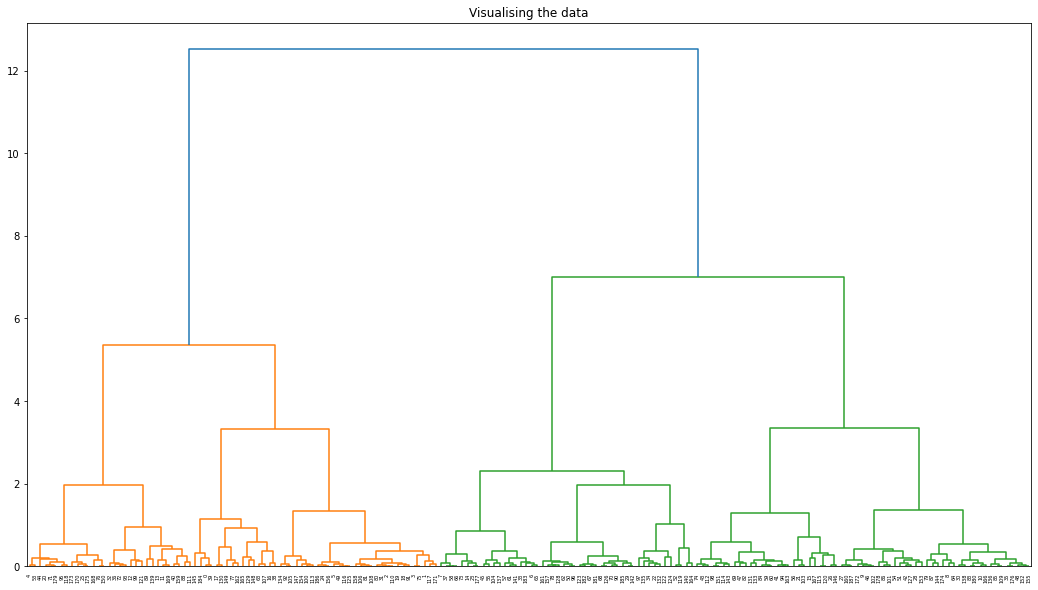

In [55]:
# Visualizing the working of the Dendograms
plt.figure(figsize =(18, 10))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(df_pca, method ='ward')))

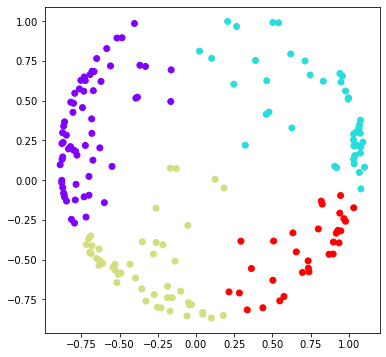

In [54]:
# Building and Visualizing the different clustering models for different values of k
ac4 = AgglomerativeClustering(n_clusters = 4)
  
# Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(df_pca['P1'], df_pca['P2'], 
           c = ac4.fit_predict(df_pca), cmap ='rainbow')
plt.show()

In [57]:
predict_sector = ac4.fit_predict(df_pca)

In [58]:
df_pca.head()

,P1,P2
0,0.459032,0.413470
1,1.079806,-0.055799
2,1.053235,0.218184
3,0.907972,0.086911
4,0.870805,-0.466866


In [59]:
predict_sector

array([1, 1, 1, 1, 3, 1, 2, 2, 0, 0, 0, 3, 3, 3, 2, 0, 1, 1, 1, 1, 3, 0,
       2, 2, 1, 3, 0, 0, 0, 2, 0, 1, 3, 2, 2, 0, 3, 2, 1, 1, 3, 0, 0, 0,
       3, 2, 0, 0, 0, 1, 2, 0, 2, 3, 0, 2, 0, 2, 2, 0, 0, 2, 2, 1, 0, 2,
       2, 2, 2, 0, 2, 3, 3, 2, 0, 1, 3, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       3, 3, 2, 1, 1, 3, 0, 3, 2, 2, 0, 3, 1, 0, 0, 0, 2, 1, 1, 1, 1, 0,
       1, 3, 0, 1, 0, 0, 1, 1, 3, 2, 0, 3, 2, 2, 2, 1, 2, 0, 2, 1, 1, 0,
       2, 0, 1, 2, 0, 2, 0, 3, 2, 2, 2, 0, 0, 1, 0, 1, 1, 1, 3, 0, 0, 0,
       1, 0, 1, 2, 1, 3, 0, 2, 1, 0, 2, 1, 0, 0, 3, 3, 3, 1, 0, 3, 0, 3,
       0, 2, 0, 3, 0, 2, 2, 2, 1, 2, 1, 0])

In [60]:
# convierto a df
clustering = pd.DataFrame({'ticker':df_returns.index,'cluster':predict_sector}).set_index('ticker')
clustering.head()

,cluster
ticker,
AAPL,1
ACN,1
ADBE,1
ADI,1
ADP,3


In [64]:
sp500.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota"
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois"
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois"
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts"
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland"


In [68]:
sp500_tickers = sp500[sp500['Symbol'].isin(tickers_companias)]

In [75]:
df_sectores = sp500_tickers[['Symbol', 'GICS Sector']]
df_sectores.set_index('Symbol', inplace=True)
df_sectores

,GICS Sector
Symbol,
ACN,Information Technology
ADBE,Information Technology
AMD,Information Technology
AES,Utilities
AFL,Financials
...,...
WLTW,Financials
XEL,Utilities
XLNX,Information Technology


In [77]:
df_concat = pd.concat([clustering, df_sectores], axis=1)
df_concat.head()

,cluster,GICS Sector
AAPL,1,Information Technology
ACN,1,Information Technology
ADBE,1,Information Technology
ADI,1,Information Technology
ADP,3,Information Technology


In [80]:
print(df_concat[df_concat['cluster'] == 0].value_counts())
print(df_concat[df_concat['cluster'] == 1].value_counts())
print(df_concat[df_concat['cluster'] == 2].value_counts())
print(df_concat[df_concat['cluster'] == 3].value_counts())

cluster  GICS Sector           
0        Financials                32
         Energy                    20
         Information Technology     9
         Utilities                  2
dtype: int64
cluster  GICS Sector           
1        Information Technology    38
         Financials                 8
dtype: int64
cluster  GICS Sector           
2        Utilities                 24
         Information Technology    12
         Financials                11
         Energy                     1
dtype: int64
cluster  GICS Sector           
3        Information Technology    15
         Financials                14
         Utilities                  2
dtype: int64


#### Se puede observar que al clusterizar obtenemos 4 grupos bien diferenciados, pero que al compararlos con la verdadera clasificacion concluimos que las features no son suficientes para agruparlos por sector.

## Probemos los clusters!

Una vez que se haya podido realizar el clustering y estemos "conformes", elijamos un nivel de linkage que nos permita tener 4 clusters y construyamos la siguiente estrategia de inversión:
- Elegir una acción de cada cluster aleatoriamente
- Invertir el 25% del dinero en cada una de ellas
- La estrategia corre durante todo 2021 hasta finales de agosto
- Comenzar con $10.000

Grafiquemos el avance de la misma, junto al avance del S&P500 y calculemos el Sharpe Ratio de cada una de ellas.

In [95]:
clustering['ticker'] = clustering.index

In [94]:
cluster_1 = [0]
cluster_2 = [1]
cluster_3 = [2]
cluster_4 = [3]

clustering_1 = clustering.loc[clustering['cluster'].isin(cluster_1)]
clustering_2 = clustering.loc[clustering['cluster'].isin(cluster_2)]
clustering_3 = clustering.loc[clustering['cluster'].isin(cluster_3)]
clustering_4 = clustering.loc[clustering['cluster'].isin(cluster_4)]

tickers_1 = list(clustering_1['ticker']) # ticker acciones cluster 0
tickers_2 = list(clustering_2['ticker']) 
tickers_3 = list(clustering_3['ticker']) 
tickers_4 = list(clustering_4['ticker']) 

print(f'tickers del cluster 0 {tickers_1}')
print(f'tickers del cluster 1 {tickers_2}')
print(f'tickers del cluster 2 {tickers_3}')
print(f'tickers del cluster 3 {tickers_4}')

tickers del cluster 0 ['AES', 'AFL', 'AIG', 'AMAT', 'APA', 'AXP', 'BAC', 'BEN', 'BKR', 'C', 'CFG', 'CINF', 'CMA', 'CNP', 'COF', 'COP', 'CTRA', 'CVX', 'DFS', 'DVN', 'DXC', 'EOG', 'FANG', 'FITB', 'GLW', 'HAL', 'HBAN', 'HES', 'HIG', 'HPE', 'HPQ', 'IVZ', 'KEY', 'KMI', 'L', 'LNC', 'MET', 'MPC', 'MRO', 'MS', 'MU', 'NTAP', 'OKE', 'OXY', 'PBCT', 'PFG', 'PRU', 'PSX', 'PXD', 'RF', 'RJF', 'SCHW', 'SLB', 'STT', 'SYF', 'TFC', 'TRMB', 'USB', 'VLO', 'WDC', 'WFC', 'WMB', 'ZION']
tickers del cluster 1 ['AAPL', 'ACN', 'ADBE', 'ADI', 'ADSK', 'AMD', 'AMP', 'ANET', 'ANSS', 'AVGO', 'BLK', 'CDAY', 'CDNS', 'CRM', 'ENPH', 'FLT', 'FTNT', 'GPN', 'GS', 'INTU', 'IPGP', 'KLAC', 'LRCX', 'MA', 'MCHP', 'MCO', 'MKTX', 'MPWR', 'MSCI', 'MSFT', 'NOW', 'NVDA', 'NXPI', 'PAYC', 'PTC', 'PYPL', 'QCOM', 'QRVO', 'SIVB', 'SNPS', 'SPGI', 'SWKS', 'TER', 'TYL', 'XLNX', 'ZBRA']
tickers del cluster 2 ['AEE', 'AEP', 'ALL', 'APH', 'ATO', 'BK', 'BRK.B', 'BRO', 'CBOE', 'CMS', 'CSCO', 'CTSH', 'D', 'DTE', 'DUK', 'ED', 'EIX', 'ES', 'ETR', 'E

#### Selecciono una accion por cluster al azar.

- cluster 0: GLW: Corning Incorporated is an American multinational technology company that specializes in specialty glass, ceramics, and related materials and technologies including advanced optics, primarily for industrial and scientific applications
- cluster 1: ADBE: Adobe Inc., originally called Adobe Systems Incorporated, is an American multinational computer software company
- cluster 2: ORCL: Oracle is an American multinational computer technology corporation headquartered in Austin, Texas. 
- cluster 3: TXN: Texas Instruments Incorporated is an American technology company headquartered in Dallas, Texas, that designs and manufactures semiconductors and various integrated circuits, which it sells to electronics designers and manufacturers globally.


In [98]:
yf.pdr_override()

# download dataframe
start = "2021-01-01"
end = "2021-09-30"

df_2021 = data.get_data_yahoo('GLW ADBE ORCL TXN', start=start, end=end)
df_2021.head()

[*********************100%***********************]  4 of 4 completed


Adj Close                                         Close  \
                  ADBE        GLW       ORCL         TXN        ADBE   
Date                                                                   
2021-01-04  485.339996  34.309586  63.000999  159.467789  485.339996   
2021-01-05  485.690002  35.046474  62.220280  160.637604  485.690002   
2021-01-06  466.309998  36.254974  62.071480  161.433868  466.309998   
2021-01-07  477.739990  36.333580  62.567493  165.090759  477.739990   
2021-01-08  485.100006  36.304100  62.875023  168.256119  485.100006   

                                                    High             ...  \
                  GLW       ORCL         TXN        ADBE        GLW  ...   
Date                                                                 ...   
2021-01-04  34.919998  63.750000  162.220001  500.790009  36.230000  ...   
2021-01-05  35.669998  62.959999  163.410004  486.079987  35.849998  ...   
2021-01-06  36.900002  62.570000  164.220001  475.869995  37.570000  ...   
2021-01-07  36.980000  63.070000  167.940002  479.640015  37.459999  ...   
2021-01-08  36.950001  63.380001  171.160004  485.540009  37.230000  ...   

                  Low                    Open                        \
                 ORCL         TXN        ADBE        GLW       ORCL   
Date                                                                  
2021-01-04  63.169998  160.759995  500.299988  36.049999  64.690002   
2021-01-05  62.480000  161.279999  485.880005  34.959999  63.680000   
2021-01-06  61.910000  162.070007  474.100006  36.200001  62.270000   
2021-01-07  62.849998  164.820007  471.000000  37.259998  62.849998   
2021-01-08  62.910000  168.860001  480.000000  37.130001  63.180000   

                         Volume                              
                   TXN     ADBE      GLW      ORCL      TXN  
Date                                                         
2021-01-04  164.600006  3612900  4999800  11249900  4659900  
2021-01-05  161.699997  2010100  4774800  11005700  4734100  
2021-01-06  162.300003  4156600  5470400   8685400  5254400  
2021-01-07  165.330002  2901200  4477700   7382800  5673600  
2021-01-08  171.119995  2266100  4144900   7751700  4556500  

[5 rows x 24 columns]

In [100]:
# Retornos unitarios en 'Adj Close'

tickers_selec = ['GLW', 'ADBE', 'ORCL', 'TXN']

for ticker in tickers_selec:
    df_2021['returns', ticker] = df_2021['Adj Close', ticker].pct_change()

In [110]:
i0_glw = 2500.0
i0_adbe = 2500.0
i0_glw = 2500.0
i0_glw = 2500.0

In [117]:
for ticker in tickers_selec:
    p0 = df_2021['Adj Close', ticker][0]
    p1 = df_2021['Adj Close', ticker][-1]
    va = (p1 / p0)-1
    ganancia = va * 2500
    inversion_final = (p1 / p0) * 2500
    print(f'la ganancia de {ticker} es de {ganancia}')
    print(f'la inversion final de {ticker} es de {inversion_final}')

la ganancia de GLW es de 205.5122096247608
la inversion final de GLW es de 2705.512209624761
la ganancia de ADBE es de 475.7490448244461
la inversion final de ADBE es de 2975.749044824446
la ganancia de ORCL es de 1120.974301821568
la inversion final de ORCL es de 3620.9743018215677
la ganancia de TXN es de 526.786928298198
la inversion final de TXN es de 3026.786928298198


## Agregado Opcional

Si disponemos de más tiempo, podemos intentar elegir nuestras acciones desde los clusters de manera más inteligente. Por ejemplo, en vez de hacerlo de manera aleatoria, podemos elegir la que tenga la menor volatilidad, o la que tenga el mejor rendimiento predecible según algún indicador técnico o modelo que hayamos podido entrenar en los prácticos 3 y 4.

También podemos hacer que la estrategia cambie de acciones por día o mes de acuerdo al criterio que se elija. Graficar nuevamente estas estrategias y compararlas con el índice.